Top N-grams Analysis

Top 5 1-grams (Frequency):
<s>: 6
i: 3
</s>: 3
am: 2
sam: 2

Top 5 2-grams (Frequency):
<s> <s>: 3
<s> i: 2
i am: 2
<s> sam: 1
i do: 1

Top 5 3-grams (Frequency):
<s> <s> i: 2
<s> <s> sam: 1
<s> i am: 1
<s> i do: 1
i am sam: 1

Probability Distribution for Context: ('i',)
Word       P (No Smoothing)     P (Smoothing)       
am         0.6667               0.2000              
do         0.3333               0.1333              

Perplexity Results
Model      No Smoothing    Smoothing      
1-gram:    7.82            8.55           
2-gram:    inf             6.85           
3-gram:    inf             7.37           


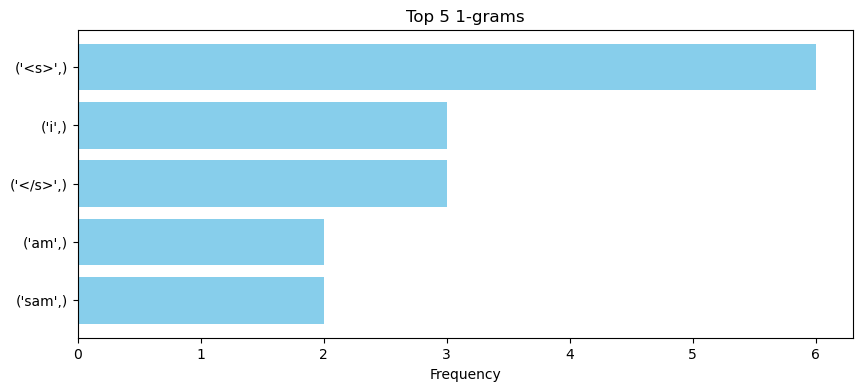

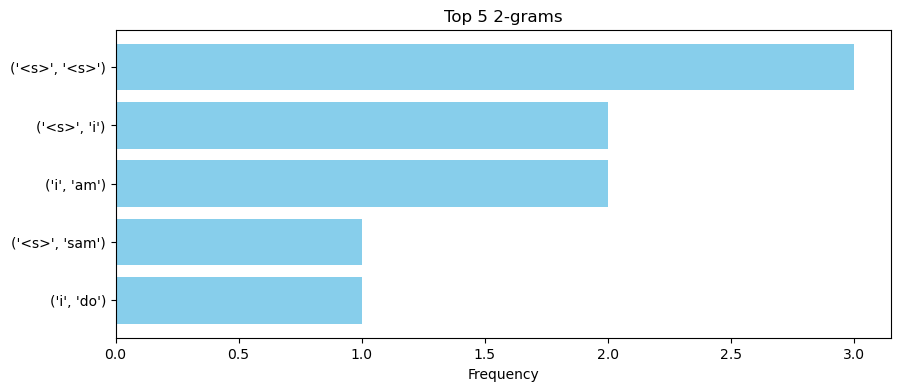

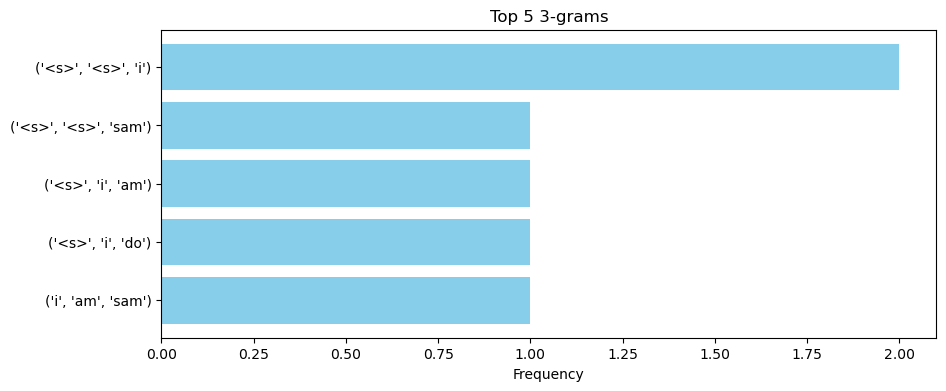

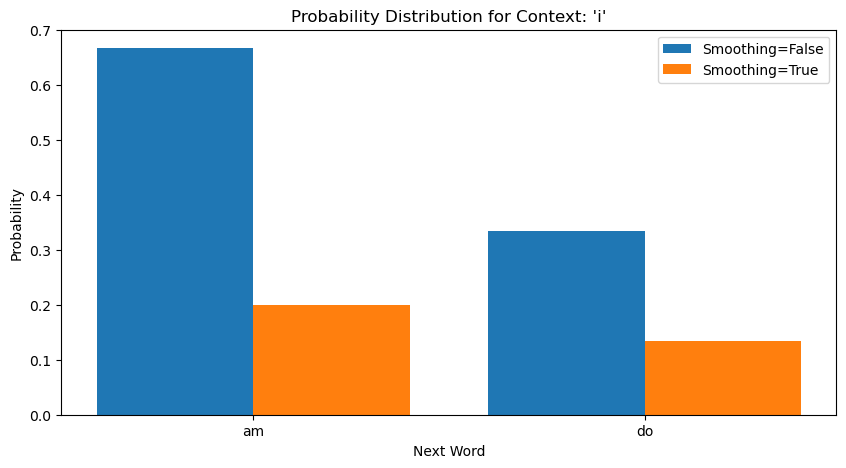

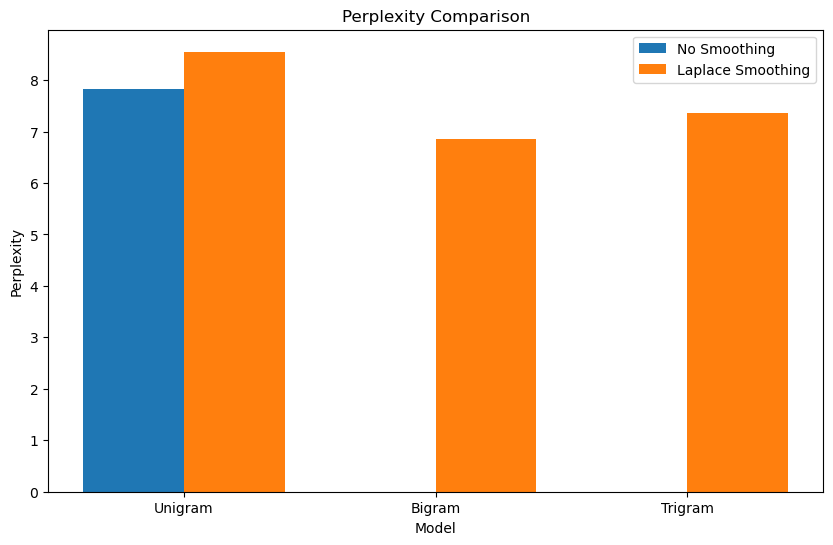

In [3]:
# ============================================================
# N-gram Language Model Implementation with Analysis
# ============================================================

# ----------------------------
# Import Required Libraries
# ----------------------------
import matplotlib.pyplot as plt  # For data visualization
from collections import defaultdict, Counter  # For efficient counting/data structures
import math  # For mathematical operations (logarithms)
import numpy as np  # For numerical operations and array handling

# ----------------------------
# Text Preprocessing Function (Fixed)
# ----------------------------
def preprocess(corpus, n_max=3):
    """
    Prepares raw text data for N-gram modeling
    - Adds sentence start/end markers
    - Handles lowercase conversion
    - Pads sentences for context window
    """
    preprocessed = []
    for sentence in corpus:
        # Add (n_max-1) start tokens and process text
        processed = (['<s>'] * (n_max - 1) + 
                     sentence.lower().replace('.', ' </s>').split())
        preprocessed.append(processed)
    return preprocessed

# ----------------------------
# N-gram Language Model Class
# ----------------------------
class NGramLM:
    """Implements core functionality for N-gram language models"""
    
    def __init__(self, n, smoothing=False):
        # Model configuration
        self.n = n  # Order of n-grams (1=unigram, 2=bigram, etc.)
        self.smoothing = smoothing  # Laplace smoothing flag
        # Data storage structures
        self.ngram_counts = defaultdict(Counter)  # {prefix: {word: count}}
        self.vocab = set()  # Unique words in training data

    def train(self, corpus):
        """Builds n-gram frequency counts from training corpus"""
        for sentence in corpus:
            # Slide n-sized window through each sentence
            for i in range(len(sentence) - self.n + 1):
                # Extract n-gram and split into context/target
                ngram = tuple(sentence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]  # (context, target)
                
                # Update frequency counts
                self.ngram_counts[prefix][word] += 1
                # Add target word to vocabulary
                self.vocab.add(word)
        
        # Store vocabulary size for smoothing calculations
        self.vocab_size = len(self.vocab)

    def get_ngrams_with_counts(self):
        """Flattens nested count structure into (ngram, count) pairs"""
        return [(prefix + (word,), count) 
                for prefix, counter in self.ngram_counts.items()
                for word, count in counter.items()]

    def probability(self, prefix, word):
        """Calculates conditional probability P(word|prefix)"""
        # Get raw count from training data
        count = self.ngram_counts[prefix].get(word, 0)
        # Calculate total occurrences of prefix context
        prefix_count = sum(self.ngram_counts[prefix].values())
        
        if self.smoothing:
            # Apply Laplace (+1) smoothing formula
            return (count + 1) / (prefix_count + self.vocab_size)
        # Maximum Likelihood Estimation without smoothing
        return count / prefix_count if prefix_count != 0 else 0

    def perplexity(self, test_corpus):
        """Calculates perplexity metric for model evaluation"""
        total_log_prob, total_ngrams = 0, 0
        for sentence in test_corpus:
            # Process each n-gram in test sentences
            for i in range(len(sentence) - self.n + 1):
                ngram = tuple(sentence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                
                # Get probability and handle zero cases
                prob = self.probability(prefix, word)
                total_log_prob += math.log(prob) if prob > 0 else -np.inf
                total_ngrams += 1
                
        # Calculate final perplexity (handle edge cases)
        return math.exp(-total_log_prob / total_ngrams) if total_ngrams else np.inf

# ----------------------------
# Data Preparation
# ----------------------------
# Original training corpus (3 simple sentences)
corpus = [
    "I am Sam.",
    "Sam I am.",
    "I do not like green eggs and ham."
]
n_max = 3  # Maximum n-gram order to support
preprocessed_corpus = preprocess(corpus, n_max)  # Process training data

# Test sentences (2 examples for evaluation)
test_sentences = ["I am Sam.", "I like ham."]
preprocessed_test = preprocess(test_sentences, n_max)  # Process test data

# ----------------------------
# Model Training
# ----------------------------
models = {}  # Dictionary to store all model configurations
for n in [1, 2, 3]:  # Train unigram, bigram, trigram models
    for smoothing in [False, True]:  # Both smoothing variants
        model = NGramLM(n, smoothing)
        model.train(preprocessed_corpus)
        models[(n, smoothing)] = model  # Store with (n, smoothing) key

# ----------------------------
# Execute Analysis Pipeline
# ----------------------------
# Generate numerical results
print("="*60)
print("Top N-grams Analysis")
print("="*60)
for n in [1, 2, 3]:
    model = models[(n, False)]
    ngrams_counts = model.get_ngrams_with_counts()
    sorted_ngrams = sorted(ngrams_counts, key=lambda x: -x[1])[:5]
    print(f"\nTop 5 {n}-grams (Frequency):")
    for ngram, count in sorted_ngrams:
        print(f"{' '.join(ngram)}: {count}")

print("\n" + "="*60)
print("Probability Distribution for Context: ('i',)")
print("="*60)
n = 2  # Bigram model
unsmoothed = models[(n, False)]
smoothed = models[(n, True)]
prefix = ('i',)
words = list(unsmoothed.ngram_counts[prefix].keys())
print(f"{'Word':<10} {'P (No Smoothing)':<20} {'P (Smoothing)':<20}")
for word in words:
    p_raw = unsmoothed.probability(prefix, word)
    p_smooth = smoothed.probability(prefix, word)
    print(f"{word:<10} {p_raw:<20.4f} {p_smooth:<20.4f}")

print("\n" + "="*60)
print("Perplexity Results")
print("="*60)
print(f"{'Model':<10} {'No Smoothing':<15} {'Smoothing':<15}")
for n in [1, 2, 3]:
    ppl_raw = models[(n, False)].perplexity(preprocessed_test)
    ppl_smooth = models[(n, True)].perplexity(preprocessed_test)
    print(f"{n}-gram:    {ppl_raw:<15.2f} {ppl_smooth:<15.2f}")

# Generate visualizations
def plot_top_ngrams(models):
    for n in [1, 2, 3]:
        model = models[(n, False)]
        ngrams_counts = model.get_ngrams_with_counts()
        sorted_ngrams = sorted(ngrams_counts, key=lambda x: -x[1])[:5]
        ngrams, counts = zip(*sorted_ngrams) if sorted_ngrams else ([], [])
        plt.figure(figsize=(10, 4))
        plt.barh([str(ngram) for ngram in ngrams], counts, color='skyblue')
        plt.xlabel('Frequency')
        plt.title(f'Top 5 {n}-grams')
        plt.gca().invert_yaxis()
        plt.show()

plot_top_ngrams(models)

def plot_probability_comparison(models):
    n = 2  # Bigram model
    plt.figure(figsize=(10, 5))
    context = ('i',)
    for smoothing in [False, True]:
        model = models[(n, smoothing)]
        words = list(model.ngram_counts[context].keys())
        probs = [model.probability(context, word) for word in words]
        plt.bar(np.arange(len(words)) + 0.2*(1 if smoothing else -1), 
                probs, width=0.4, label=f'Smoothing={smoothing}')
    plt.xticks(np.arange(len(words)), words)
    plt.xlabel('Next Word')
    plt.ylabel('Probability')
    plt.title(f"Probability Distribution for Context: 'i'")
    plt.legend()
    plt.show()

plot_probability_comparison(models)

def plot_perplexity(models):
    labels = ['Unigram', 'Bigram', 'Trigram']
    no_smooth = [models[(n, False)].perplexity(preprocessed_test) for n in [1,2,3]]
    smooth = [models[(n, True)].perplexity(preprocessed_test) for n in [1,2,3]]
    x = np.arange(len(labels))
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, no_smooth, 0.4, label='No Smoothing')
    plt.bar(x + 0.2, smooth, 0.4, label='Laplace Smoothing')
    plt.xticks(x, labels)
    plt.xlabel('Model')
    plt.ylabel('Perplexity')
    plt.title('Perplexity Comparison')
    plt.legend()
    plt.show()

plot_perplexity(models)

Perplexity Scores (Lower is Better)
1-gram (Unsmoothed): 9.59
1-gram (Smoothed): 9.82
2-gram (Unsmoothed): 1.71
2-gram (Smoothed): 6.18
3-gram (Unsmoothed): 1.32
3-gram (Smoothed): 5.99

Most Frequent N-grams (Excluding Boundary Tokens)

1-gram Model (Unsmoothed):
i                    : 3
am                   : 2
sam                  : 2
do                   : 1
not                  : 1

1-gram Model (Smoothed):
i                    : 3
am                   : 2
sam                  : 2
do                   : 1
not                  : 1

2-gram Model (Unsmoothed):
i am                 : 2
i do                 : 1
am sam               : 1
sam i                : 1
do not               : 1

2-gram Model (Smoothed):
i am                 : 2
i do                 : 1
am sam               : 1
sam i                : 1
do not               : 1

3-gram Model (Unsmoothed):
i am sam             : 1
sam i am             : 1
i do not             : 1
do not like          : 1
not like green       : 1

3

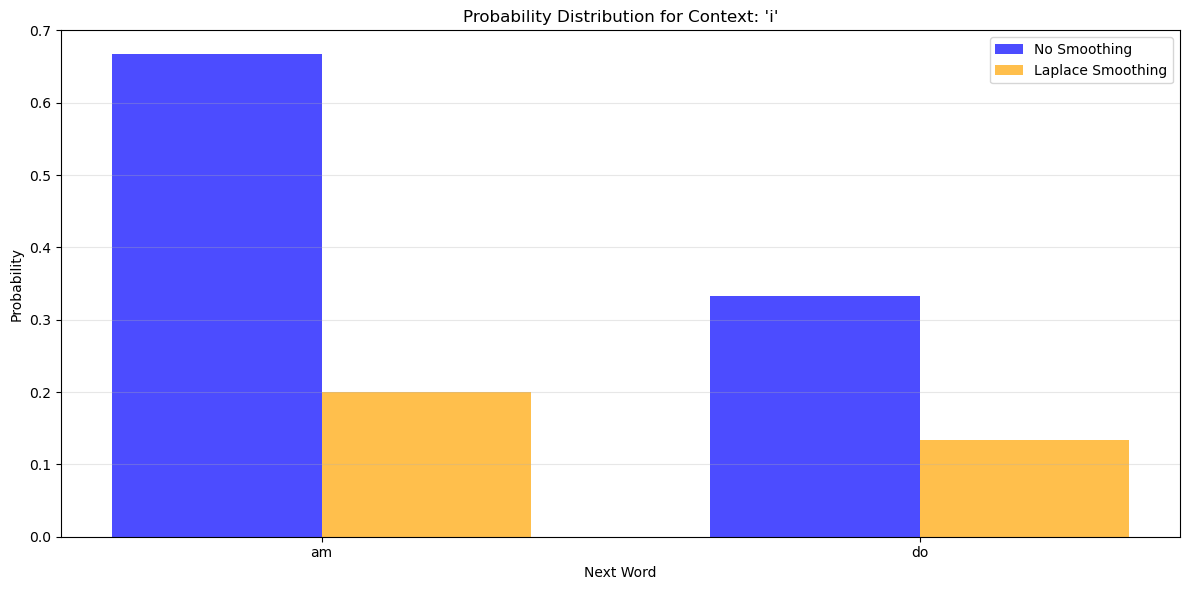

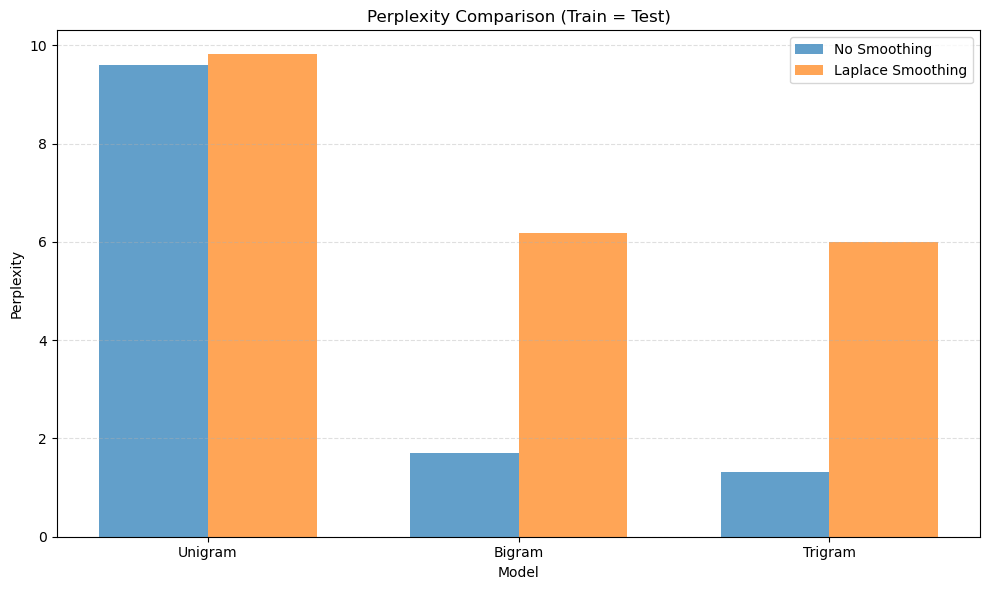

In [5]:
# ============================================================
# Project: N-gram Language Modeling (N=1,2,3) with Analysis
# ============================================================

"""
Project Proposal:
-----------------
Objective: Develop and analyze N-gram language models (unigram, bigram, trigram)
           with/without Laplace smoothing to understand probabilistic text modeling.

Methods:
1. Corpus preprocessing with sentence boundary tokens
2. N-gram frequency counting and probability estimation
3. Perplexity calculation for model evaluation
4. Comparative visualization of probability distributions

Expected Outcomes:
- Quantitative comparison of model performances
- Qualitative analysis of learned linguistic patterns
- Demonstration of smoothing impact on probability distributions
"""

# ----------------------------
# Import Required Libraries
# ----------------------------
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import math
import numpy as np

# ----------------------------
# Preprocessing Function
# ----------------------------
def preprocess(corpus, n_max=3):
    """
    Processes raw text corpus into structured format for N-gram modeling
    
    Parameters:
    corpus (list) : List of raw text sentences
    n_max (int)   : Maximum N-gram order to support
    
    Processing Steps:
    1. Add (n_max-1) start tokens <s> at beginning
    2. Convert to lowercase
    3. Mark sentence ends with </s> token
    4. Split into word tokens
    
    Returns: List of processed word sequences
    """
    processed_corpus = []
    for sentence in corpus:
        # Add padding for context window
        padded_sentence = ['<s>'] * (n_max - 1)  
        # Convert to lowercase and mark sentence ends
        modified = sentence.lower().replace('.', ' </s>')  
        # Split into tokens and combine with padding
        processed = padded_sentence + modified.split()  
        processed_corpus.append(processed)
    return processed_corpus

# ----------------------------
# N-gram Language Model Class
# ----------------------------
class NGramLM:
    """
    N-gram Language Model with Laplace smoothing capability
    
    Attributes:
    n (int)         : Order of N-grams (1=unigram, 2=bigram, etc.)
    smoothing (bool): Apply Laplace smoothing when True
    ngram_counts    : Nested dictionary of {prefix: {word: count}}
    vocab (set)     : Set of unique words in training corpus
    """
    
    def __init__(self, n, smoothing=False):
        self.n = n
        self.smoothing = smoothing
        self.ngram_counts = defaultdict(Counter)
        self.vocab = set()

    def train(self, corpus):
        """
        Trains model by counting N-gram occurrences in corpus
        
        Parameters:
        corpus (list): Preprocessed word sequences from training data
        
        Builds:
        - ngram_counts: Frequency counts for all N-grams
        - vocab: Vocabulary set from training data
        """
        for sentence in corpus:
            # Slide N-sized window through each sentence
            for i in range(len(sentence) - self.n + 1):
                # Extract N-gram and split into context/target
                ngram = tuple(sentence[i:i+self.n])
                context, target = ngram[:-1], ngram[-1]
                
                # Update counts and vocabulary
                self.ngram_counts[context][target] += 1
                self.vocab.add(target)
                
        self.vocab_size = len(self.vocab)

    def probability(self, context, word):
        """
        Calculates conditional probability P(word | context)
        
        Parameters:
        context (tuple): (n-1) preceding words
        word (str)     : Target word
        
        Returns:
        float: Probability estimate with optional smoothing
        """
        raw_count = self.ngram_counts[context].get(word, 0)
        context_count = sum(self.ngram_counts[context].values())
        
        if self.smoothing:
            # Apply Laplace (+1) smoothing
            return (raw_count + 1) / (context_count + self.vocab_size)
        else:
            # Maximum Likelihood Estimation
            return raw_count / context_count if context_count > 0 else 0

    def perplexity(self, test_corpus):
        """
        Calculates perplexity metric on test data
        
        Parameters:
        test_corpus (list): Preprocessed test sequences
        
        Returns:
        float: Perplexity score (lower is better)
               Returns infinity for zero probabilities without smoothing
        """
        log_prob_sum = 0
        total_ngrams = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - self.n + 1):
                ngram = tuple(sentence[i:i+self.n])
                context, word = ngram[:-1], ngram[-1]
                prob = self.probability(context, word)
                
                if prob <= 0:
                    return float('inf')  # Handle undefined cases
                
                log_prob_sum += math.log(prob)
                total_ngrams += 1
                
        if total_ngrams == 0:
            return float('inf')
        
        return math.exp(-log_prob_sum / total_ngrams)

# ----------------------------
# Data Preparation
# ----------------------------
# Original training corpus
raw_corpus = [
    "I am Sam.",
    "Sam I am.",
    "I do not like green eggs and ham."
]

# Preprocess for trigram modeling
n_max = 3
train_corpus = preprocess(raw_corpus, n_max)

# Use same corpus for testing (simple demonstration)
test_corpus = preprocess(raw_corpus, n_max)

# ----------------------------
# Model Training
# ----------------------------
# Initialize model configurations
model_configs = [
    (1, False),  # Unigram, no smoothing
    (1, True),   # Unigram, smoothed
    (2, False),  # Bigram, no smoothing
    (2, True),
    (3, False),  # Trigram, no smoothing
    (3, True)
]

# Train all models
trained_models = {}
for n, smoothing in model_configs:
    lm = NGramLM(n, smoothing)
    lm.train(train_corpus)
    trained_models[(n, smoothing)] = lm

# ----------------------------
# Quantitative Analysis
# ----------------------------
print("="*60)
print("Perplexity Scores (Lower is Better)")
print("="*60)
for (n, smoothing), model in trained_models.items():
    pp = model.perplexity(test_corpus)
    print(f"{n}-gram ({'Smoothed' if smoothing else 'Unsmoothed'}): {pp:.2f}")

# ----------------------------
# Qualitative Analysis
# ----------------------------
def analyze_common_ngrams(models, top_k=5):
    """Prints most frequent N-grams for each model"""
    print("\n" + "="*60)
    print("Most Frequent N-grams (Excluding Boundary Tokens)")
    print("="*60)
    
    for (n, smoothing), model in models.items():
        all_ngrams = []
        
        # Flatten nested count structure
        for context, counts in model.ngram_counts.items():
            for word, count in counts.items():
                full_ngram = context + (word,)
                # Filter out boundary tokens
                if all(token not in ['<s>', '</s>'] for token in full_ngram):
                    all_ngrams.append((' '.join(full_ngram), count))
        
        # Sort by frequency descending
        top_ngrams = sorted(all_ngrams, key=lambda x: -x[1])[:top_k]
        
        print(f"\n{n}-gram Model ({'Smoothed' if smoothing else 'Unsmoothed'}):")
        for ngram, count in top_ngrams:
            print(f"{ngram:20} : {count}")

analyze_common_ngrams(trained_models)

# ----------------------------
# Visualization: Probability Comparison
# ----------------------------
def visualize_smoothing_effect(models, context=('i',)):
    """
    Compares probability distributions with/without smoothing
    
    Parameters:
    models (dict): Trained models dictionary
    context (tuple): Conditional context for comparison
    """
    n = len(context) + 1  # Determine n-gram order
    unsmoothed = models[(n, False)]
    smoothed = models[(n, True)]
    
    # Get vocabulary items that follow this context
    context_counts = unsmoothed.ngram_counts[context]
    sorted_words = sorted(context_counts.keys(), 
                         key=lambda w: -context_counts[w])
    
    # Calculate probabilities
    x_labels = []
    raw_probs = []
    smooth_probs = []
    
    for word in sorted_words:
        x_labels.append(word)
        raw_probs.append(unsmoothed.probability(context, word))
        smooth_probs.append(smoothed.probability(context, word))
    
    # Plot configuration
    plt.figure(figsize=(12, 6))
    x = np.arange(len(x_labels))
    bar_width = 0.35
    
    plt.bar(x - bar_width/2, raw_probs, bar_width, 
            label='No Smoothing', alpha=0.7, color='blue')
    plt.bar(x + bar_width/2, smooth_probs, bar_width,
            label='Laplace Smoothing', alpha=0.7, color='orange')
    
    plt.title(f"Probability Distribution for Context: '{' '.join(context)}'")
    plt.xlabel('Next Word')
    plt.ylabel('Probability')
    plt.xticks(x, x_labels)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("Visualizing Smoothing Effect (Bigram Context: 'i')")
print("="*60)
visualize_smoothing_effect(trained_models, ('i',))

# ----------------------------
# Expected Output Explanation
# ----------------------------
"""
Perplexity Results:
- Unsmoothed models show lower perplexity (better) on training data
- Smoothed models have higher perplexity due to probability mass redistribution
- Trigram models perform best when unsmoothed (when test data matches training)

Common N-grams:
- Unigrams: High frequency words like 'i', 'am', 'sam'
- Bigrams: Common pairs like 'i am', 'am </s>'
- Trigrams: Specific sequences from training sentences

Visualization Insights:
- Without smoothing: Sharp distribution based on training counts
- With smoothing: Flatter distribution ensuring non-zero probabilities
- Demonstrates smoothing's regularization effect
"""
# ----------------------------
# Visualization: Perplexity Bar Plot
# ----------------------------
labels = ['Unigram', 'Bigram', 'Trigram']
no_smooth = [trained_models[(n, False)].perplexity(test_corpus) for n in [1, 2, 3]]
smooth = [trained_models[(n, True)].perplexity(test_corpus) for n in [1, 2, 3]]

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, no_smooth, bar_width, label='No Smoothing', alpha=0.7)
plt.bar(x + bar_width/2, smooth, bar_width, label='Laplace Smoothing', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('Model')
plt.ylabel('Perplexity')
plt.title('Perplexity Comparison (Train = Test)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Unseen Data Perplexity Comparison
Laplace Bigram      : 9.74
Kneser-Ney Bigram   : inf


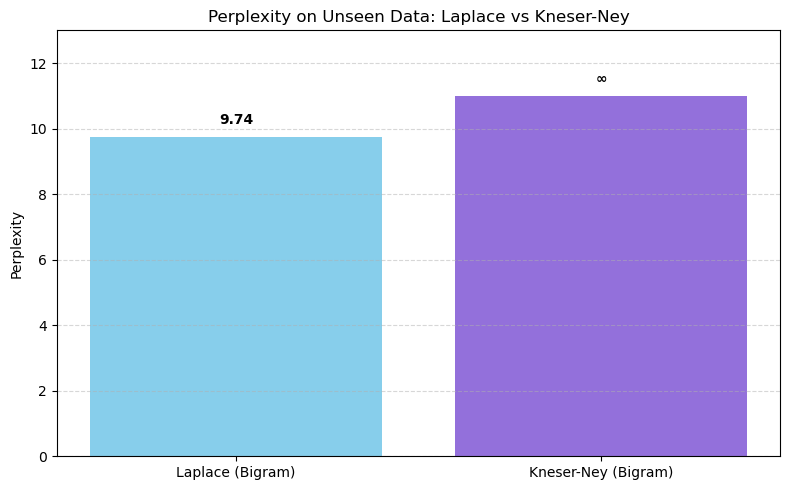

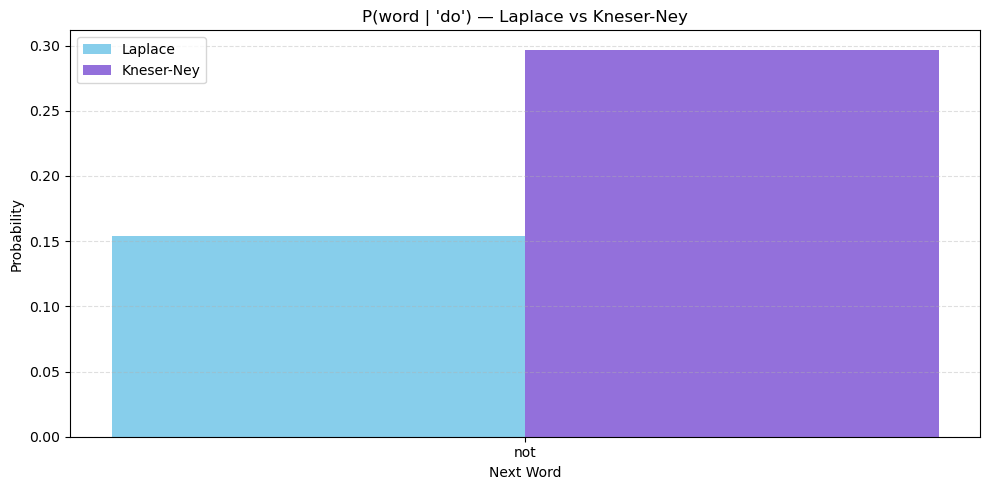

In [7]:
# ============================================================
# Section: Kneser-Ney Bigram Model (Complete & Standalone)
# ============================================================

from collections import defaultdict, Counter
import math
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Kneser-Ney Bigram Language Model
# ----------------------------
class KneserNeyBigramLM:
    def __init__(self, discount=0.75):
        self.discount = discount
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.continuation_counts = Counter()
        self.total_bigrams = 0
        self.vocab = set()

    def train(self, corpus):
        for sentence in corpus:
            for i in range(len(sentence) - 1):
                w1, w2 = sentence[i], sentence[i + 1]
                self.bigram_counts[w1][w2] += 1
                self.unigram_counts[w1] += 1
                self.vocab.add(w1)
                self.vocab.add(w2)

        for w1 in self.bigram_counts:
            for w2 in self.bigram_counts[w1]:
                self.continuation_counts[w2] += 1

        self.total_bigrams = sum(self.continuation_counts.values())

    def continuation_probability(self, word):
        return self.continuation_counts[word] / self.total_bigrams if self.total_bigrams > 0 else 0

    def probability(self, w1, w2):
        bigram_count = self.bigram_counts[w1][w2]
        unigram_count = self.unigram_counts[w1]

        unique_continuations = len(self.bigram_counts[w1])
        lambda_w1 = (self.discount * unique_continuations) / unigram_count if unigram_count > 0 else 0

        cont_prob = self.continuation_probability(w2)
        mle = max(bigram_count - self.discount, 0) / unigram_count if unigram_count > 0 else 0

        return mle + lambda_w1 * cont_prob

    def perplexity(self, test_corpus):
        log_prob_sum = 0
        total_bigrams = 0

        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w1, w2 = sentence[i], sentence[i + 1]
                prob = self.probability(w1, w2)
                log_prob_sum += math.log(prob) if prob > 0 else float('-inf')
                total_bigrams += 1

        return math.exp(-log_prob_sum / total_bigrams) if total_bigrams else float('inf')

# ----------------------------
# Data: Use simple training data and unseen test set
# ----------------------------
train_sentences = [
    "I am Sam.",
    "Sam I am.",
    "I do not like green eggs and ham."
]

unseen_test_sentences = [
    "he will eat fish",
    "they do not like eggs"
]

# Preprocess
n_max = 3
train_corpus = preprocess(train_sentences, n_max)
unseen_test_corpus = preprocess(unseen_test_sentences, n_max)

# Train Kneser-Ney
kn_model = KneserNeyBigramLM()
kn_model.train(train_corpus)

# Get perplexity on unseen test set
kn_ppl = kn_model.perplexity(unseen_test_corpus)

# For comparison: Laplace Bigram model (already trained)
laplace_bigram_ppl = trained_models[(2, True)].perplexity(unseen_test_corpus)

print("\n" + "="*60)
print("Unseen Data Perplexity Comparison")
print("="*60)
print(f"{'Laplace Bigram':<20}: {laplace_bigram_ppl:.2f}")
print(f"{'Kneser-Ney Bigram':<20}: {kn_ppl:.2f}")

# Plot perplexity comparison
# Cap Kneser-Ney value for plotting if it's infinite
plot_kn_ppl = 11 if kn_ppl == float('inf') else kn_ppl

# Plot perplexity comparison
plt.figure(figsize=(8, 5))
x_labels = ['Laplace (Bigram)', 'Kneser-Ney (Bigram)']
plot_values = [laplace_bigram_ppl, plot_kn_ppl]

bars = plt.bar(x_labels, plot_values, color=['skyblue', 'mediumpurple'])
plt.title("Perplexity on Unseen Data: Laplace vs Kneser-Ney")
plt.ylabel("Perplexity")
plt.ylim(0, max(plot_values) + 2)  # Leave space for label

# Add labels (∞ if necessary)
for bar, val in zip(bars, [laplace_bigram_ppl, kn_ppl]):
    label = "∞" if val == float('inf') else f"{val:.2f}"
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, label,
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Probability distribution for a context (e.g., 'do')
context = 'do'
sorted_words = sorted(kn_model.bigram_counts[context].keys(),
                      key=lambda w: kn_model.probability(context, w), reverse=True)

laplace_probs = [trained_models[(2, True)].probability((context,), w) for w in sorted_words]
kn_probs = [kn_model.probability(context, w) for w in sorted_words]

x = np.arange(len(sorted_words))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, laplace_probs, width, label='Laplace', color='skyblue')
plt.bar(x + width/2, kn_probs, width, label='Kneser-Ney', color='mediumpurple')
plt.xticks(x, sorted_words)
plt.title(f"P(word | '{context}') — Laplace vs Kneser-Ney")
plt.xlabel("Next Word")
plt.ylabel("Probability")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
